In [2]:
import glob
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import scipy             as sci
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.database.load_db as dbf
import invisible_cities.reco.xy_algorithms as xyf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.kdst_io as kdstio
import invisible_cities.io.dst_io as dstio

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.core.stat_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import measurement_string

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units_c import units

Running on  Sun Jun 17 20:43:34 2018


In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [21]:
dbf.DataSiPM(5797)[(dbf.DataSiPM(5797).X == -65) & (dbf.DataSiPM(5797).Y == -135)]

,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
778,13010,13010,1,-65.0,-135.0,17.2537,2.48535


In [30]:
dbf.DataSiPM(5797)[np.array(bool(dbf.DataSiPM(5797).Active.values))]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [41]:
print(dbf.DataSiPM(5797).SensorID[7])

1007


In [35]:
dbf.DataSiPM(5797)[(dbf.DataSiPM(5797).X == 115) & (dbf.DataSiPM(5797).Y == 95)].Active

1373    0
Name: Active, dtype: int64

In [77]:
def lifetime_calculation(z, zrange, energy, erange, elim_min, elim_max, slope_min, slope_max, axes):
    axes[0].hist(energy, 50, erange)
    labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")

    low_cut   = elim_min * np.exp(-slope_min*z)
    high_cut  = elim_max * np.exp(-slope_max*z)
    sel       = coref.in_range(energy, low_cut, high_cut) # remove low and high E background

    axes[1].hist2d(z, energy, (100, 50), range=(zrange, erange))
    x, y, u_y = fitf.profileX(z[sel], energy[sel], 100, xrange=zrange, yrange=erange)

    axes[1].plot(x, y, profOpt)
    axes[1].plot(z,  low_cut, "k.")
    axes[1].plot(z, high_cut, "k.")

    Zrange_LT = zrange
    
    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    axes[1].plot(x, f.fn(x), fitOpt, lw=4)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          \n".format(f.chi2))

    axes[1].text(zrange[0] + 0.1*(zrange[1]-zrange[0]), erange[0] + 1000, \
                "Lifetime = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]), color = "white", fontsize = 30)
    
    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

    return np.array([-f.values[1], f.errors[1]]), corrf.LifetimeCorrection(-f.values[1], f.errors[1])

In [74]:
inputfiles[-1:]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5847_v0.9.6-42-g4033926_20180612_kr.h5']

In [10]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/5863/kdst/kdst*.h5")
kdst = dstio.load_dsts(inputfiles[:], "DST", "Events")

In [18]:
kdst = kdst.sort_values('event')

In [24]:
bins = np.linspace(kdst.time.values[0], kdst.time.values[-1], 1001)

counts = []

for i, time in enumerate(bins[:-1]):
    sel = coref.in_range(kdst.time, bins[i], bins[i+1])
    counts = len(kdst[sel])/(bins[i+1] - bins[i])

In [26]:
counts

8.7873388755532424

Energy at z=0 = 12160.5 +- 10.3
Lifetime      = 1194.6 +- 3.8
Chi2          = 3.36          



(array([ 1194.621815  ,     3.78253977]),
 <invisible_cities.reco.corrections.Fcorrection at 0x110c47c88>)

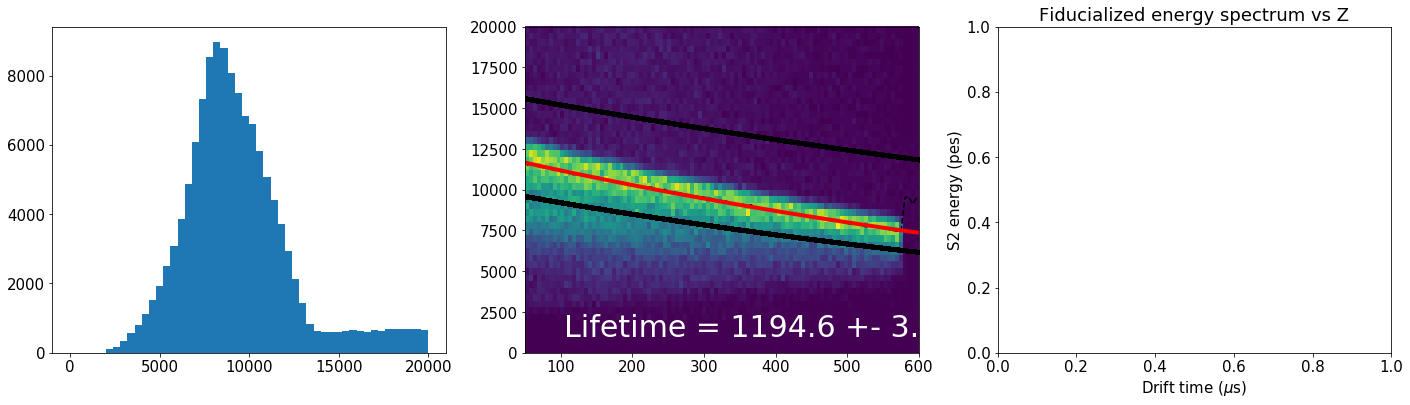

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(24,6))

lifetime_calculation(kdst.Z, [50., 600], kdst.S2e, [0, 20000], 10000, 16000, 0.0008, 0.0005, ax)

In [85]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*.h5")

In [86]:
inputfiles[-1:]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5798_v0.9.6-29-g2ec1284_20180607_kr.h5']

In [87]:
kdst = dstio.load_dsts(inputfiles[-1:], "DST", "Events")

Energy at z=0 = 11413.1 +- 13.2
Lifetime      = 1879.0 +- 12.6
Chi2          = 2.13          



(array([ 1879.01508534,    12.55700511]),
 <invisible_cities.reco.corrections.Fcorrection at 0x11b61edd8>)

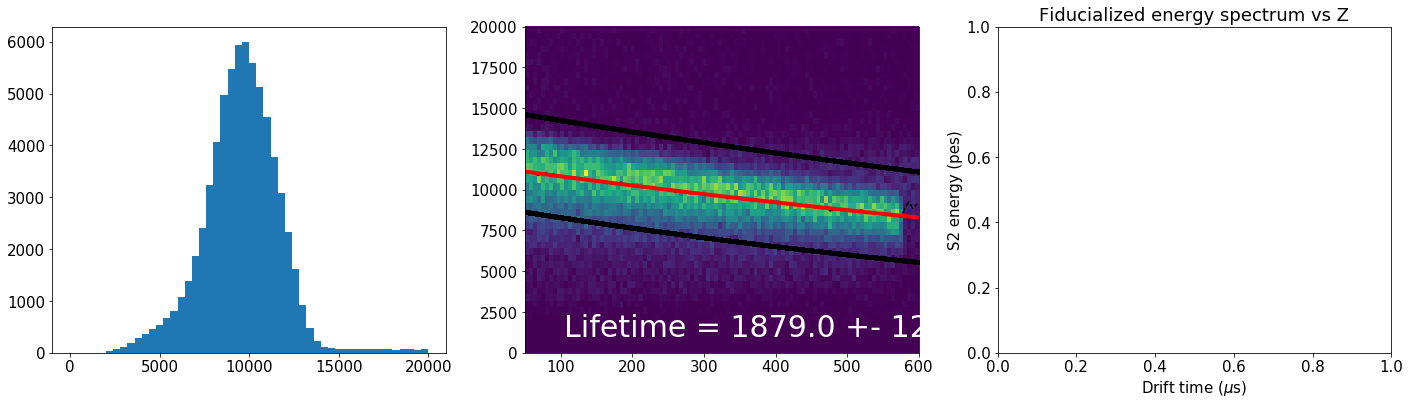

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(24,6))

lifetime_calculation(kdst.Z, [50., 600], kdst.S2e, [0, 20000], 9000, 15000, 0.0008, 0.0005, ax)

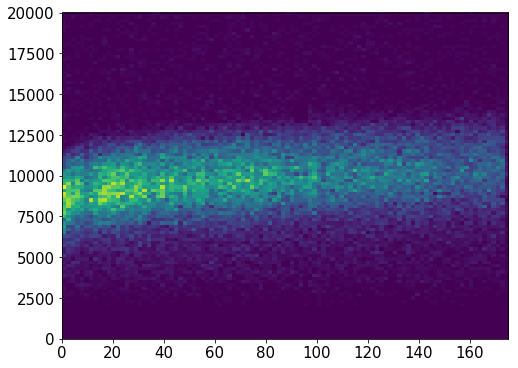

In [95]:
times = kdst.time.values/60
hist2d(times - times[0], kdst.S2e, 100, [[0, 175], [0, 20000]]);

In [92]:
kdst.time

0        1.528402e+09
1        1.528402e+09
2        1.528402e+09
3        1.528402e+09
4        1.528402e+09
5        1.528402e+09
6        1.528402e+09
7        1.528402e+09
8        1.528402e+09
9        1.528402e+09
10       1.528402e+09
11       1.528402e+09
12       1.528402e+09
13       1.528402e+09
14       1.528402e+09
15       1.528402e+09
16       1.528402e+09
17       1.528402e+09
18       1.528402e+09
19       1.528402e+09
20       1.528402e+09
21       1.528402e+09
22       1.528402e+09
23       1.528402e+09
24       1.528402e+09
25       1.528402e+09
26       1.528402e+09
27       1.528402e+09
28       1.528402e+09
29       1.528402e+09
             ...     
70136    1.528412e+09
70137    1.528412e+09
70138    1.528412e+09
70139    1.528412e+09
70140    1.528412e+09
70141    1.528412e+09
70142    1.528412e+09
70143    1.528412e+09
70144    1.528412e+09
70145    1.528412e+09
70146    1.528412e+09
70147    1.528412e+09
70148    1.528412e+09
70149    1.528412e+09
70150    1

In [277]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*kr.h5")

In [279]:
inputfiles

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5781_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5782_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5784_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5786_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5787_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5789_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5796_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5797_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5798_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5799_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5800_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/a

In [265]:
inputfiles[2:3]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5786_v0.9.6-29-g2ec1284_20180607_kr.h5']

In [281]:
kdst_all = dstio.load_dsts(inputfiles[:], "DST", "Events")

In [282]:
kdst_all

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,Zrms,X,Y,R,Xrms,Yrms
0,1,1.528310e+09,0,1,200.0,2.829743,12.553860,373225.0,10.497375,2524.046143,...,6.525076e+05,20,279.282625,279.282625,1.687338,111.830831,47.505303,121.502627,9.658405,13.540196
1,2,1.528310e+09,0,1,150.0,2.729273,12.329385,563500.0,6.483750,3487.639160,...,6.534754e+05,18,89.975375,89.975375,1.174400,-62.484606,-149.802222,162.311527,13.024256,28.695629
2,3,1.528310e+09,0,1,225.0,1.688274,11.700369,79625.0,12.427437,1803.213379,...,6.534862e+05,24,573.861250,573.861250,2.366045,92.931017,-50.314376,105.677388,30.682166,27.842761
3,6,1.528310e+09,0,1,150.0,2.862537,13.925118,108350.0,13.426750,1553.639893,...,6.544822e+05,27,546.132187,546.132187,2.432249,-156.672151,-55.530740,166.222219,12.063512,12.081448
4,7,1.528310e+09,0,1,325.0,1.324388,12.261250,172575.0,11.274688,1773.921143,...,6.544866e+05,27,481.911563,481.911563,2.180445,-139.333545,5.032041,139.424381,31.120532,14.238846
5,8,1.528310e+09,0,1,150.0,0.929361,5.137903,580250.0,7.566375,3645.564697,...,6.524714e+05,21,72.221438,72.221438,1.345079,120.752088,-23.683731,123.052777,45.392568,18.236946
6,9,1.528310e+09,0,1,175.0,2.606208,12.670249,637700.0,6.535312,8397.540039,...,6.513526e+05,20,13.652625,13.652625,0.475474,-107.415216,1.550589,107.426407,12.625923,14.488359
7,18,1.528310e+09,0,1,200.0,2.876103,16.484632,448950.0,8.199500,1569.190308,...,6.524994e+05,21,203.549438,203.549438,1.520155,-33.338847,-196.180665,198.993297,10.818261,9.966723
8,19,1.528310e+09,0,1,275.0,1.041760,9.691679,564750.0,6.339000,4384.311523,...,6.524600e+05,24,87.710000,87.710000,0.959296,-23.624498,113.074593,115.516149,28.707188,52.521725
9,20,1.528310e+09,0,1,125.0,1.800422,7.551466,566025.0,6.662000,4077.573730,...,6.524789e+05,19,86.453875,86.453875,1.035155,-36.353432,-164.034041,168.014103,9.471932,13.314706


In [267]:
kdst = kdst_all[~kdst_all.event.duplicated()]

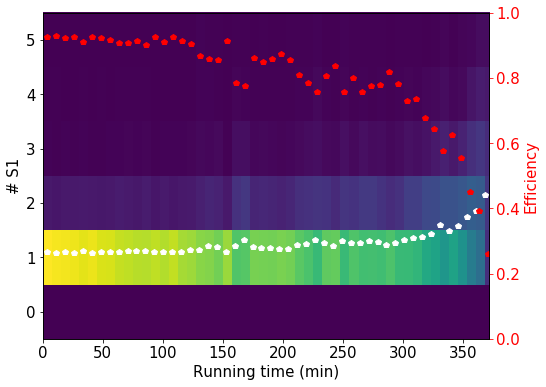

In [235]:
times = (kdst.time.values - kdst.time.values[0])/60
xc, yc, *_ =hist2d(times, kdst.nS1, [50, 6], [[0, 375], [-0.5, 5.5]]);
x, y, u_y = fitf.profileX(times, kdst.nS1, 50, xrange=[0,times[-1]], yrange=[0, 5])
eff = np.array([c[1]/c.sum() for c in xc])
plt.errorbar(x, y, u_y, fmt='wp')
plt.xlabel("Running time (min)")
plt.ylabel("# S1")
ax = plt.twinx()
ax.errorbar(yc, eff, fmt='rp')
ax.set_ylabel("Efficiency", color='r')
ax.tick_params('y', colors='r')
ax.set_ylim(0., 1.)
plt.xlim(0, times[-1])
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5784/nS1vsT.pdf')


In [192]:
eff = np.array([c[1]/c.sum() for c in xc])

In [191]:
xc[49,1]

649.0

In [190]:
xc[49].sum()

2505.0

In [189]:
len(xc)

50

In [173]:
for i, np.linspace(0., times[-1], 50)

array([   0.        ,    7.58942517,   15.17885034,   22.76827551,
         30.35770068,   37.94712585,   45.53655102,   53.12597619,
         60.71540136,   68.30482653,   75.8942517 ,   83.48367687,
         91.07310204,   98.66252721,  106.25195238,  113.84137755,
        121.43080272,  129.02022789,  136.60965306,  144.19907823,
        151.7885034 ,  159.37792857,  166.96735374,  174.55677891,
        182.14620408,  189.73562925,  197.32505442,  204.91447959,
        212.50390476,  220.09332993,  227.6827551 ,  235.27218027,
        242.86160544,  250.45103061,  258.04045578,  265.62988095,
        273.21930612,  280.80873129,  288.39815646,  295.98758163,
        303.5770068 ,  311.16643197,  318.75585714,  326.34528231,
        333.93470748,  341.52413265,  349.11355782,  356.70298299,
        364.29240816,  371.88183333])

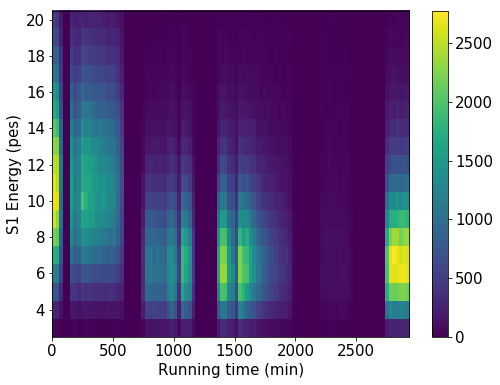

In [285]:
times = (kdst_all.time.values - kdst_all.time.values[0])/60
hist2d(times, kdst_all.S1e, [100, 18], [[0, times[-1]], [2.5, 20.5]]);
x, y, u_y = fitf.profileX(times, kdst_all.S1e, 50, xrange=[0,times[-1]], yrange=[2.5, 20.5])
#plt.errorbar(x, y, u_y, fmt='rp')
plt.xlabel("Running time (min)")
plt.ylabel("S1 Energy (pes)")
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5784/S1evsT.pdf')
plt.colorbar()

In [288]:
kdst_all.S1w

0         200.0
1         150.0
2         225.0
3         150.0
4         325.0
5         150.0
6         175.0
7         200.0
8         275.0
9         125.0
10        275.0
11        200.0
12        200.0
13        250.0
14        125.0
15        150.0
16        150.0
17        250.0
18        250.0
19        125.0
20        225.0
21        125.0
22        225.0
23        175.0
24        125.0
25        125.0
26        400.0
27        350.0
28        150.0
29        125.0
          ...  
120862    125.0
120863    375.0
120864    150.0
120865    250.0
120866    125.0
120867    175.0
120868    200.0
120869    125.0
120870    275.0
120871    425.0
120872    200.0
120873    225.0
120874    200.0
120875    125.0
120876    225.0
120877    150.0
120878    125.0
120879    400.0
120880    150.0
120881    175.0
120882    150.0
120883    125.0
120884    125.0
120885    150.0
120886    150.0
120887    225.0
120888    175.0
120889    150.0
120890    150.0
120891    150.0
Name: S1w, Length: 70052

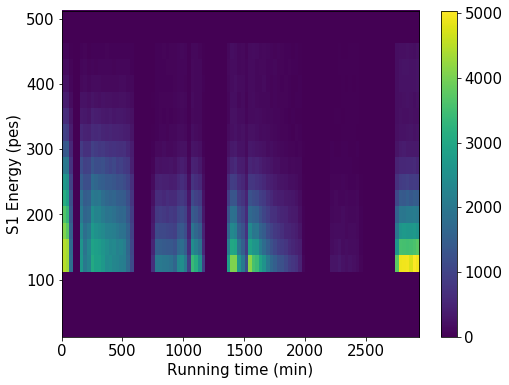

In [292]:
times = (kdst_all.time.values - kdst_all.time.values[0])/60
hist2d(times, kdst_all.S1w, [100, 20], [[0, times[-1]], [12.5, 512.5]]);
x, y, u_y = fitf.profileX(times, kdst_all.S1w, 50, xrange=[0,times[-1]], yrange=[0., 500])
#plt.errorbar(x, y, u_y, fmt='rp')
plt.xlabel("Running time (min)")
plt.ylabel("S1 Energy (pes)")
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5784/S1evsT.pdf')
plt.colorbar()

In [215]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*.h5")

In [216]:
inputfiles[4:5]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5798_v0.9.6-29-g2ec1284_20180607_kr_dev.h5']

In [238]:
kdst_all = dstio.load_dsts(inputfiles[4:5], "DST", "Events")

In [239]:
kdst = kdst_all[~kdst_all.event.duplicated()]

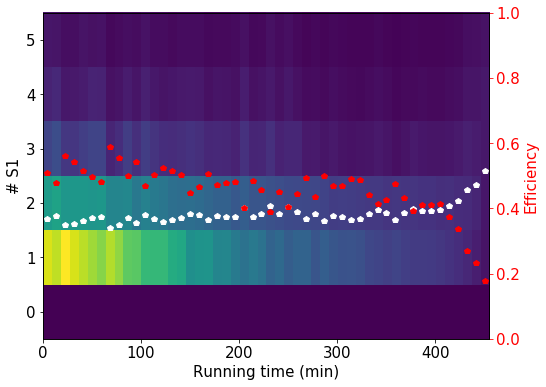

In [240]:
times = (kdst.time.values - kdst.time.values[0])/60
xc, yc, *_ =hist2d(times, kdst.nS1, [50, 6], [[0, times[-1]], [-0.5, 5.5]]);
x, y, u_y = fitf.profileX(times, kdst.nS1, 50, xrange=[0,times[-1]], yrange=[0, 5])
eff = np.array([c[1]/c.sum() for c in xc])
plt.errorbar(x, y, u_y, fmt='wp')
plt.xlabel("Running time (min)")
plt.ylabel("# S1")
ax = plt.twinx()
ax.errorbar(yc, eff, fmt='rp')
ax.set_ylabel("Efficiency", color='r')
ax.tick_params('y', colors='r')
ax.set_ylim(0., 1.)
ax.set_xlim(0, times[-1])
plt.xlim(0, times[-1])
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5798/nS1vsT.pdf')

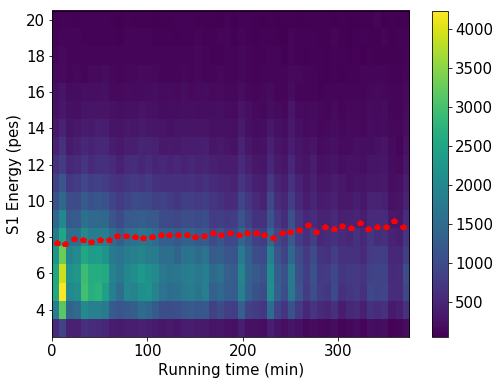

In [241]:
times = (kdst_all.time.values - kdst_all.time.values[0])/60
hist2d(times, kdst_all.S1e, [50, 18], [[0, 375], [2.5, 20.5]]);
x, y, u_y = fitf.profileX(times, kdst_all.S1e, 50, xrange=[0,times[-1]], yrange=[2.5, 20.5])
plt.errorbar(x, y, u_y, fmt='rp')
plt.xlabel("Running time (min)")
plt.ylabel("S1 Energy (pes)")
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5798/S1evsT.pdf')
plt.colorbar()

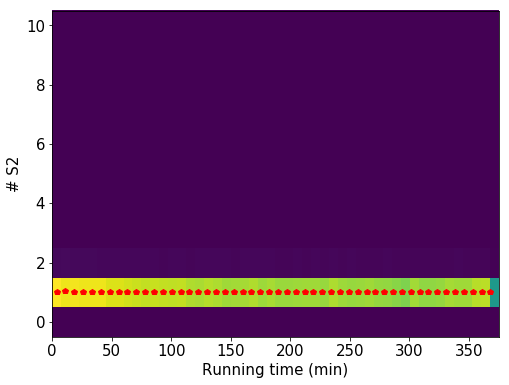

In [139]:
times = (kdst.time.values - kdst.time.values[0])/60
hist2d(times, kdst.nS2, [50, 11], [[0, 375], [-0.5, 10.5]]);
x, y, u_y = fitf.profileX(times, kdst.nS2, 50, xrange=[0,times[-1]], yrange=[0, 10])
plt.errorbar(x, y, u_y, fmt='rp')
plt.xlabel("Running time (min)")
plt.ylabel("# S2")

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,2,1.528323e+09,0,0,1,1,150.0,2.142819,10.236782,394475.0,...,21,259.021875,259.021875,1.667793,-124.750082,-91.533774,154.728842,-2.508581,10.062052,17.612157
1,3,1.528323e+09,0,0,1,1,125.0,2.606204,10.163397,490500.0,...,17,161.974813,161.974813,1.248478,-51.878724,-93.980053,107.348276,-2.075188,8.171352,9.103827
2,4,1.528323e+09,0,0,1,1,150.0,1.277868,6.930276,524725.0,...,19,127.744625,127.744625,1.186863,-152.659965,-15.245270,153.419305,-3.042058,27.392474,14.497108
3,8,1.528323e+09,0,0,1,1,225.0,2.695316,17.267742,444250.0,...,19,209.236063,209.236063,1.525114,-35.511062,-150.524764,154.656846,-1.802475,12.692244,10.373570
4,9,1.528323e+09,0,0,1,1,250.0,2.674699,15.047167,346925.0,...,21,306.551438,306.551438,1.675510,-95.901596,-18.519170,97.673311,-2.950835,12.489759,24.559670
5,10,1.528323e+09,0,0,1,1,425.0,3.970870,23.236181,316450.0,...,16,337.044250,337.044250,1.857240,86.795856,96.447214,129.752017,0.838019,10.467514,7.807569
6,11,1.528323e+09,0,0,1,1,250.0,2.343541,15.025041,162850.0,...,17,491.639187,491.639187,2.155138,106.787371,45.739701,116.170835,0.404684,12.647890,14.517346
7,12,1.528323e+09,0,0,1,1,250.0,1.721793,12.757403,125675.0,...,17,527.801125,527.801125,2.433757,48.371291,-56.811074,74.614207,-0.865466,15.114948,29.990524
8,13,1.528323e+09,0,0,1,1,200.0,3.187214,14.431773,527075.0,...,19,125.408313,125.408313,1.186951,-138.763460,-105.061151,174.049256,-2.493548,13.051961,8.495519
9,14,1.528323e+09,0,0,1,1,150.0,3.438590,16.055431,521600.0,...,19,131.855875,131.855875,1.232063,-136.679305,-86.948823,161.991760,-2.575014,9.250133,8.703303


(array([      0.,       0.,       0.,       0.,       0.,  109303.,
              0.,       0.,       0.,       0.]),
 array([ 0.55,  0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45]),
 <a list of 10 Patch objects>)

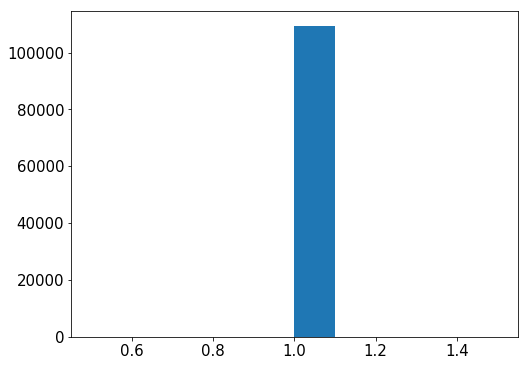

In [161]:
hist(kdst_all.nS1)

In [251]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*.h5")

In [252]:
inputfiles

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5784_v0.9.6-29-g2ec1284_20180607_kr_dev.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5796_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5797_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5798_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5798_v0.9.6-29-g2ec1284_20180607_kr_dev.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5808_v0.9.6-29-g2ec1284_20180607_kr.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5808_v0.9.6-29-g2ec1284_20180607_kr_dev.h5']

In [253]:
inputfiles[5:6]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5808_v0.9.6-29-g2ec1284_20180607_kr.h5']

In [254]:
kdst_all = dstio.load_dsts(inputfiles[5:6], "DST", "Events")

In [255]:
kdst = kdst_all[~kdst_all.event.duplicated()]

In [256]:
times = (kdst.time.values - kdst.time.values[0])/60
xc, yc, *_ =hist2d(times, kdst.nS1, [50, 6], [[0, times[-1]], [-0.5, 5.5]]);
x, y, u_y = fitf.profileX(times, kdst.nS1, 50, xrange=[0,times[-1]], yrange=[0, 5])
eff = np.array([c[1]/c.sum() for c in xc])
plt.errorbar(x, y, u_y, fmt='wp')
plt.xlabel("Running time (min)")
plt.ylabel("# S1")
ax = plt.twinx()
ax.errorbar(yc, eff, fmt='rp')
ax.set_ylabel("Efficiency", color='r')
ax.tick_params('y', colors='r')
ax.set_ylim(0., 1.)
ax.set_xlim(0, times[-1])
plt.xlim(0, times[-1])
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5798/nS1vsT.pdf')

AttributeError: 'DataFrame' object has no attribute 'nS1'

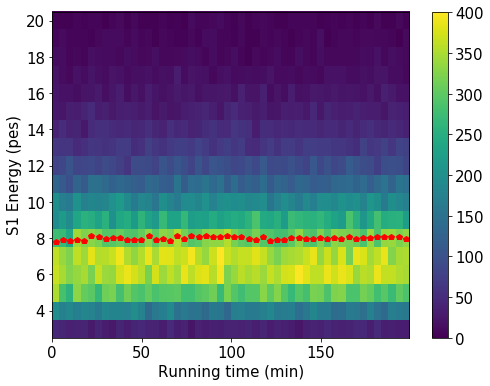

In [257]:
times = (kdst_all.time.values - kdst_all.time.values[0])/60
hist2d(times, kdst_all.S1e, [50, 18], [[0, times[-1]], [2.5, 20.5]]);
x, y, u_y = fitf.profileX(times, kdst_all.S1e, 50, xrange=[0,times[-1]], yrange=[2.5, 20.5])
plt.errorbar(x, y, u_y, fmt='rp')
plt.xlabel("Running time (min)")
plt.ylabel("S1 Energy (pes)")
plt.savefig('/Users/ansimez/Documents/InvCit/hdf5/Run4/5798/S1evsT.pdf')
plt.colorbar()

In [13]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*_dev.h5")

In [15]:
inputfiles[-1:]

['/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst_5812_v0.9.6-29-g2ec1284_20180607_kr_dev.h5']

In [16]:
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/Run4/kdst*_dev.h5")
kdst = dstio.load_dsts(inputfiles[-1:], "DST", "Events")

In [19]:
kdst_filt = kdst[(kdst.nS1 == 1) & (kdst.nS2 == 1)]

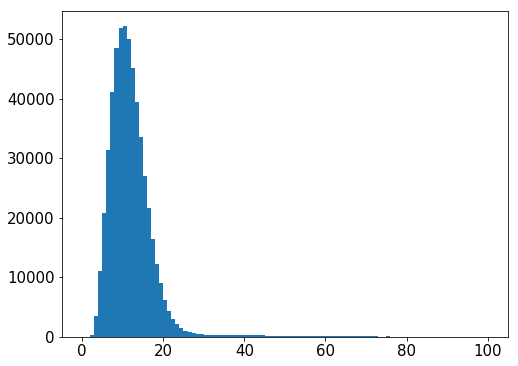

In [27]:
x, y, *_  = plt.hist(kdst_filt.S1e, 100, [0,100]);

In [35]:
y[np.argmax(x)]

10.0

In [31]:
x

array([  0.00000000e+00,   1.00000000e+00,   2.34000000e+02,
         3.43800000e+03,   1.11280000e+04,   2.07530000e+04,
         3.14430000e+04,   4.10860000e+04,   4.85090000e+04,
         5.19550000e+04,   5.22080000e+04,   5.00290000e+04,
         4.51820000e+04,   3.94200000e+04,   3.35710000e+04,
         2.69460000e+04,   2.16090000e+04,   1.65120000e+04,
         1.22530000e+04,   8.98400000e+03,   6.24700000e+03,
         4.39800000e+03,   3.07500000e+03,   2.13700000e+03,
         1.40300000e+03,   1.00300000e+03,   7.63000000e+02,
         5.90000000e+02,   4.65000000e+02,   4.18000000e+02,
         3.62000000e+02,   3.60000000e+02,   3.41000000e+02,
         3.46000000e+02,   2.97000000e+02,   3.00000000e+02,
         3.16000000e+02,   2.91000000e+02,   2.58000000e+02,
         2.60000000e+02,   2.62000000e+02,   2.53000000e+02,
         2.24000000e+02,   2.31000000e+02,   2.27000000e+02,
         2.15000000e+02,   2.10000000e+02,   1.83000000e+02,
         2.08000000e+02,

In [25]:
kdst_filt.S1e.median()

11.230374336242676

In [51]:
kdst1 = dstio.load_dst('/Users/ansimez/Documents/InvCit/hdf5/Run4/5846/kdst_5846.h5', "DST", "Events")
kdst2 = dstio.load_dst('/Users/ansimez/Documents/InvCit/hdf5/Run4/5852/kdst_5852.h5', "DST", "Events")

In [52]:
kdst1_sel = kdst1[kdst1.S2e>100000]
kdst2_sel = kdst2[kdst2.S2e>100000]

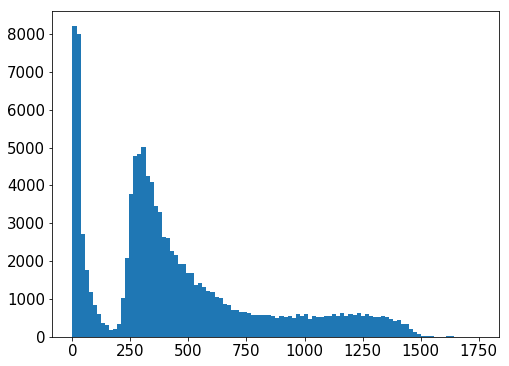

In [54]:
plt.hist(kdst1.Nsipm, 100);

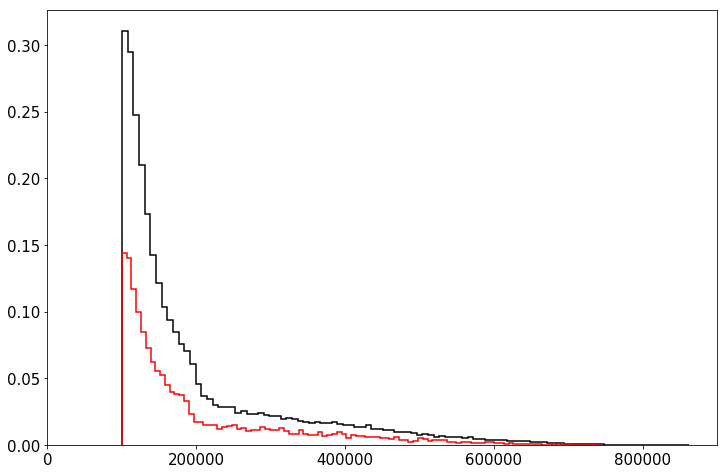

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

time1 = kdst1.time.max() - kdst1.time.min()
time2 = kdst2.time.max() - kdst2.time.min()
#plt.hist(kdst1.S2e, 100, histtype  = 'step', edgecolor = 'black', linewidth = 1.5);
plt.hist(kdst1_sel.S2e, 100, histtype  = 'step', edgecolor = 'black', linewidth = 1.5, weights = [1./time1] * len(kdst1_sel));
plt.hist(kdst2_sel.S2e, 100, histtype  = 'step', edgecolor = 'red', linewidth = 1.5, weights = [1./time2] * len(kdst2_sel));
#plt.yscale('log')
axes.set_xticks(axes.get_xticks()[::2])


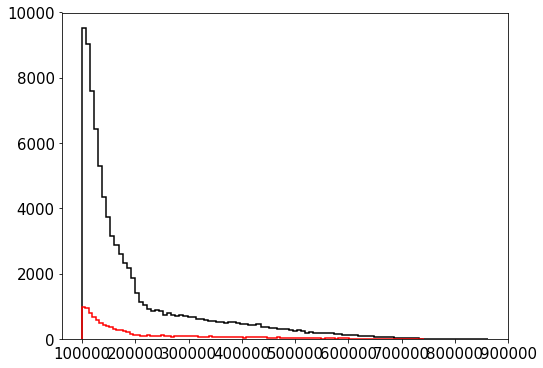

In [58]:
plt.hist(kdst1_sel.S2e, 100, histtype  = 'step', edgecolor = 'black', linewidth = 1.5);
plt.hist(kdst2_sel.S2e, 100, histtype  = 'step', edgecolor = 'red', linewidth = 1.5);

In [82]:
kdst1_sel.time

0         1.528736e+09
1         1.528736e+09
3         1.528736e+09
4         1.528736e+09
6         1.528736e+09
8         1.528736e+09
9         1.528736e+09
11        1.528736e+09
12        1.528736e+09
14        1.528736e+09
15        1.528736e+09
16        1.528736e+09
17        1.528736e+09
18        1.528736e+09
19        1.528736e+09
20        1.528736e+09
23        1.528736e+09
24        1.528736e+09
26        1.528736e+09
27        1.528736e+09
29        1.528736e+09
30        1.528736e+09
32        1.528736e+09
33        1.528736e+09
35        1.528736e+09
36        1.528736e+09
37        1.528736e+09
38        1.528736e+09
40        1.528736e+09
42        1.528736e+09
              ...     
113182    1.528767e+09
113183    1.528767e+09
113184    1.528767e+09
113185    1.528767e+09
113186    1.528767e+09
113187    1.528767e+09
113188    1.528767e+09
113190    1.528767e+09
113191    1.528767e+09
113193    1.528767e+09
113194    1.528767e+09
113195    1.528767e+09
113196    1

In [85]:
list(kdst1_sel)

['event',
 'time',
 's1_peak',
 's2_peak',
 'nS1',
 'nS2',
 'S1w',
 'S1h',
 'S1e',
 'S1t',
 'S2w',
 'S2h',
 'S2e',
 'S2q',
 'S2t',
 'Nsipm',
 'DT',
 'Z',
 'Zrms',
 'X',
 'Y',
 'R',
 'Phi',
 'Xrms',
 'Yrms']

In [86]:
kdst1_sel.DT

0         302.502502
1          30.437939
3          66.861626
4         176.544388
6          74.439255
8          55.323380
9         115.952133
11        212.736893
12        266.445374
14        382.140137
15        228.736694
16        128.798264
17        274.292023
18        301.999084
19         42.821129
20        180.538193
23        402.037140
24         80.513626
26        242.459137
27        452.485718
29        205.888138
30         59.854317
32        108.068695
33        127.139503
35        144.732819
36        228.999191
37        485.384949
38        145.176254
40        164.880692
42        127.419632
             ...    
113182    227.645004
113183    302.491028
113184     65.075127
113185    370.979065
113186    335.166199
113187    117.962440
113188    164.364319
113190    439.310699
113191    368.812775
113193    508.535583
113194    280.389771
113195    152.751511
113196    197.901505
113197     40.265877
113199    180.258072
113200    556.925842
113201     57

In [90]:
len(set(kdst1.event))

87910

In [91]:
len(kdst1)

113220

In [93]:
kdst1.event

0              1
1              2
2              2
3              4
4              5
5              5
6              6
7              6
8              7
9              9
10             9
11            10
12            12
13            12
14            14
15            15
16            16
17            17
18            19
19            21
20            22
21            22
22            22
23            23
24            25
25            25
26            26
27            27
28            27
29            28
           ...  
113190    107976
113191    107977
113192    107977
113193    107978
113194    107979
113195    107980
113196    107982
113197    107984
113198    107984
113199    107985
113200    107986
113201    107987
113202    107987
113203    107987
113204    107988
113205    107989
113206    107990
113207    107991
113208    107992
113209    107993
113210    107994
113211    107994
113212    107995
113213    107995
113214    107996
113215    107997
113216    107998
113217    1079

In [97]:
inputfiles = glob.glob('/Users/ansimez/Documents/InvCit/hdf5/Run4/5847/kdst/kdst*h5')
kdst1 = dstio.load_dsts(inputfiles, "DST", "Events")
inputfiles = glob.glob('/Users/ansimez/Documents/InvCit/hdf5/Run4/5847/kdst*h5')
kdst2 = dstio.load_dsts(inputfiles, "DST", "Events")

In [108]:
np.in1d(kdst2.event.values, kdst1.event.values)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [109]:
len(kdst2[np.in1d(kdst2.event.values, kdst1.event.values)])

138664

In [101]:
len(kdst1)

137547